In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import requests
import json
import folium
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="orlando")
#!pip3 install requests

# Getting the covid-19 data for Orange County
We begin by reading in the json file and converting it into a pandas dataframe

In [2]:
data = requests.get("https://opendata.arcgis.com/datasets/09ec2e757f91411b8e12445805cf2809_0.geojson?where=COUNTYNAME%20%3D%20'Orange'")
data = data.json()

**We want to see what keys we have and we determine that we need 'features'.  **

In [3]:
with open('data.json', 'w')as outfile:
    json.dump(data, outfile)

In [4]:
print (data.keys())
print(type(data['features']))

dict_keys(['type', 'name', 'crs', 'features'])
<class 'list'>


**We see that we get  a list of dicts so we will have have to wrangle our data in order to get it into a data frame.**

In [5]:
type(data['features'][0]['properties'])
data['features'][0]['geometry']


{'type': 'MultiPolygon',
 'coordinates': [[[[-81.58507389999994, 28.708257],
    [-81.58504169999998, 28.70797710000005],
    [-81.58363889999998, 28.707979400000056],
    [-81.58357989999996, 28.707937100000038],
    [-81.58264919999993, 28.706713800000045],
    [-81.583022, 28.70649030000004],
    [-81.58323659999996, 28.706210300000066],
    [-81.58344579999994, 28.706095100000027],
    [-81.58368719999999, 28.706003300000077],
    [-81.58405729999998, 28.70593740000004],
    [-81.58482439999995, 28.70597040000007],
    [-81.58484589999995, 28.70526220000005],
    [-81.58408119999996, 28.705134200000032],
    [-81.58387579999999, 28.705127100000027],
    [-81.58381009999994, 28.704163600000072],
    [-81.58380469999997, 28.703923700000075],
    [-81.58360989999994, 28.70392430000004],
    [-81.58342169999997, 28.70392380000004],
    [-81.583368, 28.703923700000075],
    [-81.58305649999994, 28.703922800000043],
    [-81.58086189999995, 28.703916700000036],
    [-81.58049649999998, 2

In [6]:
columns = data['features'][0]['properties'].keys()
covid_df = pd.DataFrame(columns = columns)
covid_df.shape

(0, 15)

**each item in the list below is a dict of dicts.  We have to wrangle the required data from it**

In [7]:
i = 0
for item in data['features']:
    new_dict = item['properties']
    new_dict = pd.DataFrame(new_dict, index=[i])
    covid_df = pd.concat([covid_df, new_dict])
    i=i+1
covid_df.shape

(47, 15)

In [8]:
covid_df.head()

,OBJECTID,ZIP,OBJECTID_1,DEPCODE,COUNTYNAME,FieldMatch,POName,Places,OBJECTID_12,ZIPX,c_places,Cases_1,LabelY,SHAPE_Length,SHAPE_Area
0,355,32703,683,48,Orange,Orange-32703,Apopka,"Apopka, Ocoee, Clarcona, Forest City, Lockhart...",705,Orange-32703,Apopka,140,140,0.736955,0.009063
1,359,32709,688,48,Orange,Orange-32709,Christmas,"Bithlo, Christmas, Wedgefield",706,Orange-32709,Christmas,7,7,1.494471,0.035650
2,360,32712,692,48,Orange,Orange-32712,Apopka,"Apopka, Mount Plymouth, Wekiwa Springs, Zellwood",707,Orange-32712,Apopka,145,145,0.659092,0.015048
3,376,32751,717,48,Orange,Orange-32751,Maitland,"Altamonte Springs, Eatonville, Maitland, Casse...",708,Orange-32751,Maitland,33,33,0.241671,0.001487
4,381,32757,723,48,Orange,Orange-32757,Mount Dora,"Mount Dora, Tangerine, Zellwood",709,Orange-32757,,0,0,0.566806,0.011716


**I now get the zipcode along with the number of cases**

In [9]:
covid_df = covid_df[['ZIP', 'POName', "Cases_1"]]
covid_df.columns = ['zipcode', 'neighborhood', 'cases']
covid_df['cases'].replace(to_replace="<5", value=5, inplace=True)
covid_df['cases'] = covid_df['cases'].astype(int)


**While the data retrieved above does give the boundary coordinates of each zip code, we need a specific coordinate for each zipcode to use with four square.  We use geocode to convert zipcodes to latitude, longitude**

In [10]:
def getLatLongFromZip(zipcodes): # a panda series of zipcodes should be supplied
       
    coordinates = pd.DataFrame(columns=['Latitude', 'Longitude'])
    i=0
    for zipcode in zipcodes:
        
        while(True):# geopy times out sometimes so this will run until it geopy no longer times out
            try:
                location = geolocator.geocode(str(zipcode))
                zip_coord = {"Latitude": location.latitude, "Longitude": location.longitude}
                zip_coord = pd.DataFrame(zip_coord, index=[i])
                coordinates = pd.concat([coordinates, zip_coord])
                i=i+1
                break
            except:
                pass
    return coordinates
   

In [11]:
coordinates = getLatLongFromZip(covid_df['zipcode'])


In [12]:
coordinates.head()

,Latitude,Longitude
0,28.663529,-81.474428
1,28.564218,-81.065553
2,28.726430,-81.521900
3,28.628243,-81.354615
4,28.819383,-81.683776


In [71]:
covid_df['Latitude'] = coordinates.Latitude
covid_df['Longitude'] = coordinates.Longitude
covid_df

,zipcode,neighborhood,cases,Latitude,Longitude
0,32703,Apopka,140,28.663529,-81.474428
1,32709,Christmas,7,28.564218,-81.065553
2,32712,Apopka,145,28.726430,-81.521900
3,32751,Maitland,33,28.628243,-81.354615
4,32757,Mount Dora,0,28.819383,-81.683776
5,32776,Sorrento,0,28.817921,-81.548751
6,32789,Winter Park,55,28.594368,-81.384780
7,32792,Winter Park,58,28.599850,-81.301531
8,32798,Zellwood,5,28.717705,-81.576182
9,32801,Orlando,87,28.543426,-81.378020


**When I was almost completely done with the analysis, I realized that some of my zipcodes did not convert to coordinates correctly.  I found it easier to manually fix them here**

In [14]:
def replaceLatLong(changes, df):
    for item in changes:
        index = df[df['zipcode']==item[0]].index.values
        df.at[index, 'Latitude'] = item[1]
        df.at[index,'Longitude'] = item[2]
    return df

In [98]:

changes = [['32805', '28.5346', '81.4004'],
          ['32839', '28.4889', '81.4114'],
          ['32816', '28.6013', '81.2009'],
          ['32825', '28.5417', '81.2409'],
          ['34734', '28.5391', '81.5185'],
          ['32820', '28.5808', '81.1306'],
          ['32776', '28.8132', '-81.5048'],
          ['32757', '28.7520', '-81.6364']]
covid_df = replaceLatLong(changes, covid_df)


**We now use the Foursquare API to find features for each zipcode**

In [99]:
covid_df.shape

(47, 5)

In [100]:
CLIENT_ID = 'RKRACHUNPQLEQHK1NMYXSP3DR2YE3BRYBDRCBBC2LB1SR503'# your Foursquare ID
CLIENT_SECRET = 'DJQGSGGER5JVH4NREDDUJCDVIQ52VPM0IXDVGRXYQ4QGSUNB' # your Foursquare Secret
VERSION = '202006017' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RKRACHUNPQLEQHK1NMYXSP3DR2YE3BRYBDRCBBC2LB1SR503
CLIENT_SECRET:DJQGSGGER5JVH4NREDDUJCDVIQ52VPM0IXDVGRXYQ4QGSUNB


**We create a function to get nearby venues of each zipcode**

In [101]:
def getNearbyVenues(zipcodes, latitudes, longitudes,radius=1000):
    
    LIMIT = 100
    venues_list=[]
    for zipcode, lat, lng in zip(zipcodes, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [102]:
orange_venues = getNearbyVenues(zipcodes=covid_df.zipcode,
                            latitudes=covid_df.Latitude,
                            longitudes=covid_df.Longitude)
orange_venues.shape

(1083, 7)

In [103]:
orange_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,32703,28.6635,-81.4744,Shoot Straight,28.659116,-81.475502,Sporting Goods Shop
1,32703,28.6635,-81.4744,Family Dollar,28.656188,-81.471007,Discount Store
2,32703,28.6635,-81.4744,Rodeway Inn,28.659738,-81.476128,Hotel
3,32703,28.6635,-81.4744,7-Eleven,28.655540,-81.470543,Convenience Store
4,32703,28.6635,-81.4744,Long John Silver's,28.672488,-81.474008,Seafood Restaurant


**Now we do one hot encoding so that we can run kmeans clustering**

In [104]:
orange_onehot = pd.get_dummies(orange_venues[['Venue Category']], prefix="", prefix_sep="")
orange_onehot['zipcode'] = orange_venues['Neighborhood']
fixed_columns = [orange_onehot.columns[-1]] + list(orange_onehot.columns[:-1])
orange_onehot = orange_onehot[fixed_columns]
orange_grouped = orange_onehot.groupby('zipcode').mean().reset_index()
orange_grouped.head()

,zipcode,Accessories Store,Airport,Airport Service,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,32703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,32712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,32751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.045455,...,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,32757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
orange_grouped.shape

(35, 232)

**I now run k means clustering to cluster the zipcodes**

In [106]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [107]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['zipcode'] = orange_grouped['zipcode']

for ind in np.arange(orange_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(orange_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(15)

,zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,32703,Convenience Store,Seafood Restaurant,Sporting Goods Shop,Outlet Store,Baseball Field,Pet Store,Discount Store,Hotel,Deli / Bodega,Department Store
1,32712,Art Gallery,Business Service,Tree,Zoo,Eastern European Restaurant,Food Court,Food & Drink Shop,Food,Fish Market,Financial or Legal Service
2,32751,Sandwich Place,Pizza Place,Coffee Shop,Mediterranean Restaurant,Park,Gas Station,Chinese Restaurant,Lake,Korean Restaurant,Pharmacy
3,32757,Lake,Boat or Ferry,Zoo,Electronics Store,Food Truck,Food Court,Food & Drink Shop,Food,Fish Market,Financial or Legal Service
4,32789,Greek Restaurant,Vegetarian / Vegan Restaurant,Gas Station,Electronics Store,Taco Place,Chiropractor,Lake,Pet Store,Pharmacy,Clothing Store
5,32792,Fast Food Restaurant,American Restaurant,Convenience Store,Intersection,Pizza Place,Mexican Restaurant,Seafood Restaurant,Sandwich Place,Ice Cream Shop,Restaurant
6,32798,American Restaurant,Pool,Zoo,Eastern European Restaurant,Food Court,Food & Drink Shop,Food,Fish Market,Financial or Legal Service,Fast Food Restaurant
7,32801,Bar,Coffee Shop,Cocktail Bar,Lounge,American Restaurant,Pizza Place,Hotel,Restaurant,French Restaurant,Bed & Breakfast
8,32803,Vietnamese Restaurant,Grocery Store,Asian Restaurant,Vegetarian / Vegan Restaurant,Convenience Store,Bar,Taco Place,Smoke Shop,Chinese Restaurant,Martial Arts Dojo
9,32804,Ice Cream Shop,Café,Sandwich Place,American Restaurant,Pizza Place,Park,Salon / Barbershop,Italian Restaurant,Intersection,BBQ Joint


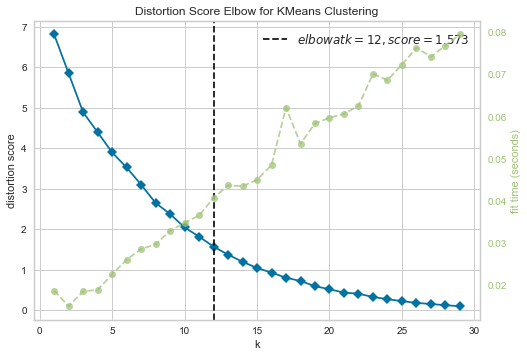

In [108]:
#!pip3 install yellowbrick #uncomment if you have not installed yellowbric
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
grouped_clusters = orange_grouped.drop('zipcode', 1)
visualizer = KElbowVisualizer(model, k = (1,30))
visualizer.fit(grouped_clusters)
visualizer.show()

**Based on the elbox method above, we should use 9 clusters**

In [109]:
kclusters = 13
kmeans = KMeans(n_clusters=kclusters, ).fit(grouped_clusters)
kmeans.labels_

array([ 3,  8,  3,  5,  3,  3,  7,  3,  3,  3,  3,  3,  3,  3,  4,  3,  3,
       11,  3,  2,  3,  3, 10,  3,  3,  2,  1, 12,  6,  3,  0,  3,  9,  3,
        3], dtype=int32)

In [110]:
try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    pass
    
covid_merged = covid_df
covid_merged = covid_merged.join(neighborhoods_venues_sorted.set_index('zipcode'), on='zipcode')

covid_merged = covid_merged.dropna() 
covid_merged['Cluster Labels'] = covid_merged['Cluster Labels'].astype(int)
covid_merged

,zipcode,neighborhood,cases,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,32703,Apopka,140,28.6635,-81.4744,3,Convenience Store,Seafood Restaurant,Sporting Goods Shop,Outlet Store,Baseball Field,Pet Store,Discount Store,Hotel,Deli / Bodega,Department Store
2,32712,Apopka,145,28.7264,-81.5219,8,Art Gallery,Business Service,Tree,Zoo,Eastern European Restaurant,Food Court,Food & Drink Shop,Food,Fish Market,Financial or Legal Service
3,32751,Maitland,33,28.6282,-81.3546,3,Sandwich Place,Pizza Place,Coffee Shop,Mediterranean Restaurant,Park,Gas Station,Chinese Restaurant,Lake,Korean Restaurant,Pharmacy
4,32757,Mount Dora,0,28.7520,-81.6364,5,Lake,Boat or Ferry,Zoo,Electronics Store,Food Truck,Food Court,Food & Drink Shop,Food,Fish Market,Financial or Legal Service
6,32789,Winter Park,55,28.5944,-81.3848,3,Greek Restaurant,Vegetarian / Vegan Restaurant,Gas Station,Electronics Store,Taco Place,Chiropractor,Lake,Pet Store,Pharmacy,Clothing Store
7,32792,Winter Park,58,28.5999,-81.3015,3,Fast Food Restaurant,American Restaurant,Convenience Store,Intersection,Pizza Place,Mexican Restaurant,Seafood Restaurant,Sandwich Place,Ice Cream Shop,Restaurant
8,32798,Zellwood,5,28.7177,-81.5762,7,American Restaurant,Pool,Zoo,Eastern European Restaurant,Food Court,Food & Drink Shop,Food,Fish Market,Financial or Legal Service,Fast Food Restaurant
9,32801,Orlando,87,28.5434,-81.378,3,Bar,Coffee Shop,Cocktail Bar,Lounge,American Restaurant,Pizza Place,Hotel,Restaurant,French Restaurant,Bed & Breakfast
10,32803,Orlando,79,28.5599,-81.3644,3,Vietnamese Restaurant,Grocery Store,Asian Restaurant,Vegetarian / Vegan Restaurant,Convenience Store,Bar,Taco Place,Smoke Shop,Chinese Restaurant,Martial Arts Dojo
11,32804,Orlando,36,28.5771,-81.3855,3,Ice Cream Shop,Café,Sandwich Place,American Restaurant,Pizza Place,Park,Salon / Barbershop,Italian Restaurant,Intersection,BBQ Joint


**Its starting to look like all of our data is being grouped into a signle cluster**

**Now I visualize the clusters**

In [111]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors



orange_map = folium.Map(location=[28.4845, -81.2519], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(covid_merged['Latitude'], covid_merged['Longitude'], covid_merged['zipcode'], covid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(orange_map)
       
orange_map

**As we can see almost all of our zipcodes have been clustered into one giant cluster. However, I will proceed to examine what the clusters have in common**

In [112]:
covid_merged.loc[covid_merged['Cluster Labels'] == 0, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,32836,0,Residential Building (Apartment / Condo),Home Service,Health & Beauty Service,Pool,Zoo,Farm,Eastern European Restaurant,Electronics Store,Event Space,Exhibit


In [113]:
covid_merged.loc[covid_merged['Cluster Labels'] == 1, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,32831,1,Gym,Zoo,Donut Shop,Food Court,Food & Drink Shop,Food,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market


In [114]:
covid_merged.loc[covid_merged['Cluster Labels'] == 2, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,32821,2,Theme Park Ride / Attraction,Hotel,Aquarium,Theme Park,American Restaurant,Water Park,Steakhouse,Stadium,Exhibit,Gift Shop
34,32830,2,Theme Park Ride / Attraction,Gift Shop,Snack Place,American Restaurant,Train Station,Theme Park,Ice Cream Shop,Souvenir Shop,Tourist Information Center,Resort


In [115]:
covid_merged.loc[covid_merged['Cluster Labels'] == 3, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,32703,3,Convenience Store,Seafood Restaurant,Sporting Goods Shop,Outlet Store,Baseball Field,Pet Store,Discount Store,Hotel,Deli / Bodega,Department Store
3,32751,3,Sandwich Place,Pizza Place,Coffee Shop,Mediterranean Restaurant,Park,Gas Station,Chinese Restaurant,Lake,Korean Restaurant,Pharmacy
6,32789,3,Greek Restaurant,Vegetarian / Vegan Restaurant,Gas Station,Electronics Store,Taco Place,Chiropractor,Lake,Pet Store,Pharmacy,Clothing Store
7,32792,3,Fast Food Restaurant,American Restaurant,Convenience Store,Intersection,Pizza Place,Mexican Restaurant,Seafood Restaurant,Sandwich Place,Ice Cream Shop,Restaurant
9,32801,3,Bar,Coffee Shop,Cocktail Bar,Lounge,American Restaurant,Pizza Place,Hotel,Restaurant,French Restaurant,Bed & Breakfast
10,32803,3,Vietnamese Restaurant,Grocery Store,Asian Restaurant,Vegetarian / Vegan Restaurant,Convenience Store,Bar,Taco Place,Smoke Shop,Chinese Restaurant,Martial Arts Dojo
11,32804,3,Ice Cream Shop,Café,Sandwich Place,American Restaurant,Pizza Place,Park,Salon / Barbershop,Italian Restaurant,Intersection,BBQ Joint
13,32806,3,Intersection,Spa,Convenience Store,Park,Garden Center,Pharmacy,Butcher,Lake,Lawyer,Fried Chicken Joint
14,32807,3,Convenience Store,Storage Facility,Italian Restaurant,Coffee Shop,Trade School,Gym,Donut Shop,Exhibit,Electronics Store,Event Space
15,32808,3,Construction & Landscaping,Fast Food Restaurant,Auto Workshop,Furniture / Home Store,Other Repair Shop,Outdoor Supply Store,Paper / Office Supplies Store,Park,Storage Facility,Convenience Store


In [116]:
covid_merged.loc[covid_merged['Cluster Labels'] == 4, covid_merged.columns[[0]+list(range(5, covid_merged.shape[1]))]]

,zipcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,32810,4,Construction & Landscaping,Eastern European Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market


**While it is unfortunate that almost all zipcodes went into cluster 4, we will continue making our chloropleth map to see if any association between clusters and covid-19 cases can be established**

**Earlier we got some data that included the boundaries of our zipcodes**

In [117]:
# covid_merged['cases'] = pd.to_numeric(covid_merged['cases'])
covid_df['cases'] = covid_df['cases'].astype(int)


In [118]:
len(data['features'])

47

In [119]:
covid_df.shape

(47, 5)

In [120]:

import folium
folium.Choropleth(geo_data=data,
                      data=covid_df,
                     columns=['zipcode', 'cases'],
                     fill_color='YlOrRd',
                      key_on="feature.properties.ZIP",
                     fill_opacity=0.7,
                     line_opacity=0.2,
                     legend_name='Covid Cases in Orange County by Zipcode').add_to(orange_map)

folium.LayerControl().add_to(orange_map)


In [121]:
orange_map

In [122]:
for lat, lon, poi, cluster in zip(covid_merged['Latitude'], covid_merged['Longitude'], covid_merged['zipcode'], covid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(orange_map)
    
    folium.LayerControl().add_to(orange_map)


In [123]:
orange_map

**We note that even though most zipcodes were clustered into one cluster, it is also the case that almost every zipcode within that cluster falls within a county with 68+ cases of covid.  The zipcodes either had no venues and are not represented by a circle above or fall within less than 68 cases of covid-19 to dates**